## Performance metrics for classification problems

Classification problems bring several different concepts when it comes to assess the performance of a classifier. First of all, classification may be based either on *binary* or *multinomial* response variables. Although similar, these two settings of classification require attention when calculating metrics for evaluation. In addition to statistics suited for multinomial problems (for example, multinomial deviance), some metrics used for binary problems, such as precision, recall, and F1 score, should be calculated for each class separetely (see references for sources with detailed discussion on metrics for multiclass classification).
<br>
<br>
This notebook focus on performance metrics for binary classification, even though some ideas or results may also hold for multinomial problems. A *statistical learning method* is applied to estimate a model $f(.)$ referenced by *parameters* $\theta$. These parameters determine how inputs $X$ define the output $Y$. When the response variable is binary, $Y \in \{0, 1\}$, such as for the dataset used here, the estimation of $\theta$ leads to the calculation of a *score* $P(y = 1|x, \hat{\theta})$ for a given data point $x$.
<br>
<br>
Metrics of performance for binary classification problems may either compare true labels with scores or true labels with predicted classes, where these follow from opposing scores with a predefined threshold to allocate data points to $Y = 1$ or to $Y = 0$. Not just that, some metrics may be explicitly dependent on the choice of a given threshold, or may consider several diffent thresholds, or even may not use any threshold at all. The approach here has separated metrics into those whose value consists on a rate and those that report some kind of score. The former class of metrics is prone to use a given threshold in its calculation.
<br>
<br>
Two relevant subjects concerning classification point to *class imbalance* and *domain knowledge*. A given dataset is imbalanced when the prior probability of some class, $P(Y = 1)$ for binary problems, is too low or too high. This should raise special care when applying and interpreting any performance metric. Domaing knowledge is also crucial, since different costs may follow from different sorts of misclassification, even when there are only two possible classes.

---------------------

This notebook presents the definition and practical implementations of main metrics for classification tasks. The data used for the examples follows from Kaggle repository of datasets, and consists of a dataset for the construction of a classification algorithm for the [identification of malware apps](https://www.kaggle.com/saurabhshahane/android-permission-dataset), although only true labels and predicted scores are used here. The notebook is organized as follows: after the importing of libraries and the data, two distinct collections of metrics are approached: those that are calculated as rates comparing true and predicted labels, and, after that, those metrics which oppose predicted probabilities to the true labels. Some of the references for this study are present by the end of the notebook.

**Summary:**
1. [Libraries](#libraries)<a href='#libraries'></a>.
2. [Importing datasets](#imports)<a href='#imports'></a>.
3. [Rate metrics](#rate)<a href='#rate'> </a>.
    * [Confusion matrix](#conf_matrix)<a href='#conf_matrix'></a>.
    * [Rates from confusion matrix](#rates_conf_matrix)<a href='#rates_conf_matrix'></a>


4. [Score metrics](#score)<a href='#score'></a>.
    * [ROC curve](#roc)<a href='#roc'></a>.
    * [Precision-recall](#precision_recall)<a href='#precision_recall'></a>.
    * [F1 score](#F1)<a href='#F1'></a>.
    * [G-mean](#g_mean)<a href='#g_mean'></a>.
    * [Matthews correlation coefficient (MCC)](#mcc)<a href='#mcc'></a>.
    * [Brier score](#brier_score)<a href='#brier_score'></a>.
    * [Binomial deviance](#binomial_deviance)<a href='#binomial_deviance'></a>.
    * [Multinomial deviance](#multinomial_deviance)<a href='#multinomial_deviance'></a>.


5. [References](#references)<a href='#references'></a>.

<a id='libraries'> </a>

## Libraries

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
cd "/content/gdrive/MyDrive/Studies/Performance Metrics for Classification/Codes"

/content/gdrive/MyDrive/Studies/Performance Metrics for Classification/Codes


In [3]:
import pandas as pd
import numpy as np

import os
import json

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import f1_score, matthews_corrcoef
from sklearn.metrics import roc_auc_score, average_precision_score, brier_score_loss
from sklearn.metrics import auc, roc_curve, precision_recall_curve

<a id='imports'> </a>

## Importing data

In [4]:
# True labels (binary classification task) and predicted scores:
scores = pd.read_csv('../Datasets/test_scores.csv')
print(f'Shape of scores: {scores.shape}.')

scores.head(3)

Shape of scores: (6827, 3).


,id,y_pred,y_true
0,1,0.988038,1
1,2,0.394664,0
2,3,0.053502,0


<a id='rate'> </a>

## Rate metrics

This first kind of metrics for classification performance requires the definition of a *threshold* above which an estimated probability of $Y = 1$ points to predicting $\hat{Y} = 1$, and below which an estimated probability indicates $\hat{Y} = 0$. Although these metrics are more precise to assess how good a model is to accomplish its classification task, they rely on the definition of a threshold parameter, which is particularly tricky when the binary response variable is highly imbalanced, since $0.5$ is inappropriate in such contexts where the prior rate for $Y = 1$ is too lower or too higher than that value.

In [5]:
# Function for predicting class from estimated probability:
def class_pred(x, threshold=0.5):
    if x > threshold:
        return 1
    else:
        return 0

In [6]:
# Predicting classes:
thres = 0.5
scores['class_pred'] = scores['y_pred'].apply(class_pred, threshold=thres)

<a id='conf_matrix'> </a>

### Confusion matrix

In binary classification problems, with a response variable $Y \in \{0, 1\}$, there are two kinds of errors when predicting the label for $Y$: **false negative (type-II error)**, that occurs when $\hat{Y} = 0$ and $Y = 1$, and **false positive (type-I error)**, that holds when $\hat{Y} = 1$ and $Y = 0$. Analogously, there are also two kinds of correct predictions: **true negative**, when $Y = \hat{Y} = 0$, and **true positive**, when $Y = \hat{Y} = 1$. Confusion matrix, that actually applies similarly to multiclass classification problems, summarizes all possible events when predicting labels from a given dataset.
<br>
<br>
Not only the threshold should be chosen carefully when rate metrics are used to assess classification performance, but also which metric to focused on, since false negatives may produce more damage than false positives in some contexts, and vice-versa.

In [7]:
# Confusion matrix implementation:
conf_matrix = pd.DataFrame(data=confusion_matrix(scores['y_true'], scores['class_pred']))
conf_matrix.index.name = 'y_true'
conf_matrix.columns.name = 'y_pred'

print(f'\033[1mThreshold:\033[0m {thres}.')
conf_matrix

Threshold: 0.5.


y_pred,0,1
y_true,,
0,1880,384
1,819,3744


In [8]:
# False negatives:
FN = conf_matrix.iloc[1,0]
print(f'\033[1mFalse negatives (y_pred = 0 and y_true = 1)\033[0m: {FN}.')

False negatives (y_pred = 0 and y_true = 1): 819.


In [9]:
# True negatives:
TN = conf_matrix.iloc[0,0]
print(f'\033[1mTrue negatives (y_pred = 0 and y_true = 0)\033[0m: {TN}.')

True negatives (y_pred = 0 and y_true = 0): 1880.


In [10]:
# False positives:
FP = conf_matrix.iloc[0,1]
print(f'\033[1mFalse positives (y_pred = 1 and y_true = 0)\033[0m: {FP}.')

False positives (y_pred = 1 and y_true = 0): 384.


In [11]:
# True positives:
TP = conf_matrix.iloc[1,1]
print(f'\033[1mTrue positives (y_pred = 1 and y_true = 1)\033[0m: {TP}.')

True positives (y_pred = 1 and y_true = 1): 3744.


<a id='rates_conf_matrix'> </a>

### Rates from confusion matrix

#### False negative rate (*miss rate*)

The **false negative rate** is given by the ratio between false negatives and positives:
<br>
<br>
\begin{equation}
\displaystyle fnr = \frac{FN}{P} = \frac{FN}{(FN + TP)}
\end{equation}

In [12]:
fnr = FN/(FN + TP)
print(f'\033[1mFalse negative rate (miss rate):\033[0m {round((fnr*100), 2)}%.')

False negative rate (miss rate): 17.95%.


#### False positive rate (*fall out*)

Similarly, the **false positive rate** is given by the ratio between false positives and negatives:
<br>
<br>
\begin{equation}
\displaystyle fpr = \frac{FP}{N} = \frac{FP}{(FP + TN)}
\end{equation}

In [13]:
fpr = FP/(FP + TN)
print(f'\033[1mFalse positive rate (fall out):\033[0m {round((fpr*100), 2)}%.')

False positive rate (fall out): 16.96%.


#### Positive predictive value (*precision*)

The **positive predictive value**, also known as **precision**, is based on the total number of positive predictions $\hat{Y} = 1$. Then, it is given by the ratio between true positives and predicted positives:
<br>
<br>
\begin{equation}
\displaystyle precision = \frac{TP}{\hat{P}} = \frac{TP}{(FP + TP)}
\end{equation}

In [14]:
prec = TP/(FP + TP)
print(f'\033[1mPositive predictive value (precision):\033[0m {round((prec*100), 2)}%.')

Positive predictive value (precision): 90.7%.


#### Sensitivity (*recall*, or *true positive rate*)

The **true positive rate**, also defined as **recall** or **sensitivity**, focus on true positives, but has actual positives as the reference:
<br>
<br>
\begin{equation}
\displaystyle recall = \frac{TP}{P} = \frac{TP}{(FN + TP)}
\end{equation}

In [15]:
rec = TP/(FN + TP)
print(f'\033[1mSensitivity (recall, or true positive rate):\033[0m {round((rec*100), 2)}%.')

Sensitivity (recall, or true positive rate): 82.05%.


#### Negative predictive value

The **negative predictive value** is analogous to precision, but focused on true negatives:
<br>
<br>
\begin{equation}
\displaystyle neg\_pred = \frac{TN}{\hat{N}} = \frac{TN}{(FN + TN)}
\end{equation}

In [16]:
neg_pred = TN/(FN + TN)
print(f'\033[1mNegative predictive value:\033[0m {round((neg_pred*100), 2)}%.')

Negative predictive value: 69.66%.


#### Specificity (*true negative rate*)

The **specificity**, or **true negative rate** is similar to negative predictive value, but having as reference actual negatives instead of predicted negatives. Besides, is given by the complement to false positive rate (fall out):
<br>
<br>
\begin{equation}
\displaystyle specificity = \frac{TN}{N} = \frac{TN}{(FP + TN)}
\end{equation}

In [17]:
tnr = TN/(FP + TN)
print(f'\033[1mSpecificity (true negative rate):\033[0m {round((tnr*100), 2)}%.')

Specificity (true negative rate): 83.04%.


#### False discovery rate

The **false discovery rate** is analogous to precision, but focused on false positives instead of true positives:
<br>
<br>
\begin{equation}
\displaystyle false\_disc = \frac{FP}{\hat{P}} = \frac{TP}{(FP + TP)}
\end{equation}

In [18]:
false_disc = FP/(FP + TP)
print(f'\033[1mFalse discovery rate:\033[0m {round((false_disc*100), 2)}%.')

False discovery rate: 9.3%.


#### Error rate

The **error rate** consists on a loss function to be minimized when estimating a classification model, since it aggregates all possible errors when classifying a binary response variable (even though it also applies for multiclass classification problems). Therefore, this rate is given by dividing the sum of false negatives and false positives by the number of observations:
<br>
<br>
\begin{equation}
\displaystyle err = \frac{(FN + FP)}{(FN + TN + FP + TP)}
\end{equation}

In [19]:
err = (FN + FP)/(FN + TN + FP + TP)
print(f'\033[1mError rate:\033[0m {round((err*100), 2)}%.')

Error rate: 17.62%.


<a id='score'> </a>

## Score metrics

There is a type of metrics for classification performance that does not depend on the choice of threshold, which is particularly useful for comparing different classifiers. Moreover, these metrics reveal more clearly how good is the performance of a classifier, since they condensate information into a single statistic. Basically, they can be divided into two subtypes:
1. Those combining rates from confusion matrix ([ROC](#roc)<a href='#roc'></a>, [precision-recall](#roc)<a href='#roc'></a> curves, [F1 score](#F1)<a href='#F1'></a>, [G-mean](#g_mean)<a href='#g_mean'></a>, [MCC](#mcc)<a href='#mcc'></a>).
2. Those consisting on loss functions for classification ([Brier score](#brier_score)<a href='#brier_score'></a>, [deviance](#binomial_deviance)<a href='#binomial_deviance'></a>).

<a id='roc'> </a>

### ROC curve

ROC stands for **Receiver Operating Characteristic**, and explores the fact that rates such as false positive rate ($fpr = FP/N = FP/(FP + TN)$) and true positive rate ($tpr = TP/(FN + TP)$) are defined as a function of the threshold that assigns each data point to a class, given its estimated score.
<br>
<br>
The construction of a ROC curve involves calculating $fpr$ and $tpr$ for several different threshold, then plotting each $fpr$-$tpr$ pair in a plot where the x-axis receives the $fpr$ value, while the y-axis denotes the $tpr$ value. Consequently, a classifier with good performance has its ROC curve located near to the top-left corner of the plot, suggesting the existence of thresholds for which the $fpr$ is very low (and $tnr$ is very high) - left portion - and the $tpr$ is very high (and $fnr$ is very low) - top portion.
<br>
<br>
The baseline for ROC curve is given by the line for which $tpr = fpr$, reflecting a classifier that has as many chances of correctly predicting $Y = 1$ as of wrongly guessing positives. When the classes are balanced, such classifier is equivalent to random guessing.

#### ROC curve

In [20]:
# Implementation with sklearn:
fpr, tpr, threshold = roc_curve(scores['y_true'], scores['y_pred'])
auc_roc = auc(fpr, tpr)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


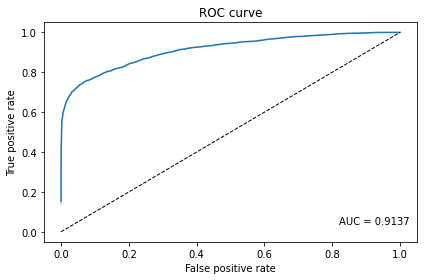

In [21]:
plt.figure(figsize=(6,4))

sns.lineplot(fpr, tpr)
plt.plot(np.linspace(0, 1, 1000), np.linspace(0, 1, 1000), '--', linewidth=1, color='black')

plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.text(0.82, 0.08, 'AUC = ' + str(round(auc_roc, 4)), fontsize=10, verticalalignment='top')

plt.tight_layout()

#### ROC-AUC score

The performance information provided by a given ROC curve is summarized through the area under the curve (AUC). The higher its value, the nearer the curve is to the top-left corner of the plot, thus suggesting a good classification performance. When it comes to comparing different classifiers, each referenced by $\theta_m$, the best model among them is that with the highest ROC-AUC value.

In [22]:
# Direct implementation with sklearn:
roc_auc_score(scores['y_true'], scores['y_pred'])

0.9137064895932795

In [23]:
# Indirect implementation:
auc(fpr, tpr)

0.9137064895932795

<a id='precision_recall'> </a>

### Precision-recall curve

**Precision** is given by the positive predictive value $TP/\hat{P} = TP/(FP + TP)$, while **recall** is equal to the true positive rate, i.e., the sensitivity $TP/P = TP/(FN + TP)$. Thus, the reference is what differences precision from recall, where the first is constructed relatively from the predictions of label $\hat{Y} = 1$ and the second is based on the number of actual positives $Y = 1$. Both precision and recall should be maximized by a classifier.
<br>
<br>
Precision and recall focus mainly in the correct prediction of label $Y = 1$, and therefore is relevant for contexts where there is a high imbalance between the classes of a binary response variable $Y$.
<br>
<br>
Since $FP$, $TP$, $FN$ and $TN$ are all entities defined by comparing a score with a given threshold, both precision and recall vary across different values for the threshold. Consequently, it is possible to plot precision-recall pairs for different thresholds, and this gives rise to the **precision-recall curve**. Such a plot has the x-axis given by recall and y-axis by precision.
<br>
<br>
The baseline for precision-recall curve is a horizontal line centered in the value of $P/(P + N)$, and the farthest the curve is to the baseline the better will be the classification model, revealing that the classifier has ability to distinguish between classes, being preferred to the random guess or the constant prediction. Irrespective of the baseline, the perfect scenario is to have a precision-recall curve touching the top-right extreme $(1, 1)$, revealing that there is one threshold for which perfect prediction of label $Y = 1$ is possible.
<br>
<br>
**Note:** since the ROC-AUC statistic uses $fpr$ (the inverse of $tnr$) in its calculation, precision-recall may be preferred to it when the data is highly imbalanced.

#### Average precision score

Precision-recall curve is very convenient to fastly assess a classification performance. However, in order to compare different classifiers, it would be preferred to summarize mathematically a given precision-recall curve. The **average precision score** is a weighted mean for precision where the weights are given by the change in recall from a threshold $t-1$ to another threshold $t$:
\begin{equation}
AP = \sum_{t=1}^T(recall_t - recall_{t-1})precision_t
\end{equation}
From this expression, a classifier referenced by $\theta_m$ is better than another constructed upon a parameter vector $\theta_{m'}$ if its average precision score is higher.

In [24]:
# Implementation with sklearn:
avg_prec = average_precision_score(scores['y_true'], scores['y_pred'])
print(avg_prec)

0.960724643422885


#### Precision-recall AUC score

Another way of summarizing the information provided by a precision-recall curve is to compute the **area under the curve**, where the higher it is the better, since the closer the curve will be to the top-right corner of the plot.
<br>
<br>
**Note:** although very similiar, precision-recall AUC and average precision score may be different.

In [25]:
# Implementation with sklearn:
precision, recall, threshold = precision_recall_curve(scores['y_true'], scores['y_pred'])
auc_prec_rec = auc(recall, precision)
ref_line = sum(scores.y_true==1)/len(scores.y_true)
print('\033[1mArea under the curve:\033[0m ' + str(round(auc_prec_rec, 4)) + '.')
print('\033[1mBaseline:\033[0m ' + str(round(ref_line, 4)) + '.')

Area under the curve: 0.9607.
Baseline: 0.6684.


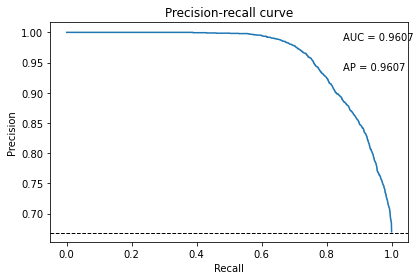

In [26]:
# Precision-recall curve:
plt.figure(figsize=(6,4))

sns.lineplot(x = recall, y = precision)

plt.axhline(ref_line, color='black', ls='--', linewidth=1)

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-recall curve')
plt.text(0.85, 1, 'AUC = ' + str(round(auc_prec_rec, 4)), fontsize=10, verticalalignment='top')
plt.text(0.85, 0.95, 'AP = ' + str(round(avg_prec, 4)), fontsize=10, verticalalignment='top')

plt.tight_layout()

<a id='F1'> </a>

### F1 score

The **F1 score** is another metric based on precision and recall. Conventionally, its defined as the harmonic average of precision and recall, thus given by:
<br>
<br>
\begin{equation}
\displaystyle F1 = \frac{2}{precision^{-1} + recall^{-1}} = 2*\frac{precision*recall}{precision + recall}
\end{equation}
<br>
<br>
Another definition takes a weight $\beta$ for how many times recall is considered as important as precision:
<br>
<br>
\begin{equation}
\displaystyle F1 = (1 + \beta^2)\frac{precision*recall}{(\beta^2)*precision + recall}
\end{equation}
<br>
<br>
For binary classification problems, main F1 score calculation is as above, while for multiclass classification settings there are mainly three ways to calculate F1: macro-F1, weighted-F1, and micro-F1. *Macro-F1* and *weighted-F1* calculate one F1 score for each class, then averaging all of them through simple average (macro-F1) or using weighted average (weighted-F1), where this weighted average takes the positives of each class as weights. *Micro-F1*, for multiclass classification problems, is given by aggregate true positives divided by aggregate positives, therefore, it is equal to accuracy (1 - error rate). It is worth to notice that micro-F1 for binary classification problems is also equal to accuracy.

In [27]:
# Manual implementation:
print(f'\033[1mBinary F1 score:\033[0m {(2*(prec*rec)/(prec + rec)):.4f}.')

Binary F1 score: 0.8616.


In [28]:
# Implementation with sklearn:
print(f'\033[1mBinary F1 score:\033[0m {f1_score(scores["y_true"], scores["class_pred"]):.4f}.')
print(f'\033[1mMacro-F1 score:\033[0m {f1_score(scores["y_true"], scores["class_pred"], average="macro"):.4f}.')
print(f'\033[1mWeighted-F1 score:\033[0m {f1_score(scores["y_true"], scores["class_pred"], average="weighted"):.4f}.')
print(f'\033[1mMicro-F1 score:\033[0m {f1_score(scores["y_true"], scores["class_pred"], average="micro"):.4f}.')

Binary F1 score: 0.8616.
Macro-F1 score: 0.8096.
Weighted-F1 score: 0.8271.
Micro-F1 score: 0.8238.


In [29]:
print(f'\033[1mMicro-F1 score for binary problems (1 - err):\033[0m {(1 - err):.4f}.')

Micro-F1 score for binary problems (1 - err): 0.8238.


<a id='g_mean'></a>

### G-mean

**G-mean** stands for *geometric mean* and is given by the root square of the product between precision and recall. Consequently, it resembles F1 in the search for adequately weighting both precision and recall.
<br>
<br>
\begin{equation}
\displaystyle g\_mean = \sqrt{precision*recall}
\end{equation}

In [30]:
print(f'\033[1mg-mean:\033[0m {np.sqrt(prec*rec):.4f}.')

g-mean: 0.8627.


<a id='mcc'> </a>

### Matthews correlation coefficient (MCC)

Matthews correlation coefficient, known as **MCC**, is another performance metrics for binary classification that is derived directly from a confusion matrix. Its mathematical formulation involves all definitions: true and false positives, true and false negatives:
<br>
<br>
\begin{equation}
\displaystyle MCC = \frac{TP*TN - FP*FN}{\sqrt{(TP+FP)*(TP+FN)*(TN+FP)*(TN+FN)}} = \frac{TP*TN - FP*FN}{\sqrt{\hat{P}*P*N*\hat{N}}} \in [-1, 1]
\end{equation}
<br>
<br>
As the name indicates, the MCC metric calculates the correlation between two random variables: true and predicted labels. Therefore, as any other correlation, this metric assumes values in the interval [-1, 1]: the closer to 1, the better the classification achieved by the trained model. Even that -1 seems the worst case scenario, it actually would lead to the opposite of a perfect classifier, since perfect accuracy could be obtained by reversing the classification suggested by the model. So, the closer a classifier gets to 0, the worse it is.

A great advantage of MCC is that it covers outcomes related to both classes, so it is not asymmetric as accuracy, precision, recall and F1, and may also help with imbalanced classes.

In [31]:
print(f'\033[1mMCC:\033[0m {matthews_corrcoef(scores["y_true"], scores["class_pred"]):.4f}.')

MCC: 0.6268.


<a id='brier_score'> </a>

### Brier score

Despite of its name, the **Brier score** can be seen as just the mean of squared-error loss function, more commonly used for regression problems. Thus, for a binary response variable $Y$, and considering a probability prediction $f(x_i; \theta)$ for data point $x_i$, the Brier score is defined by:
\begin{equation}
Brier(\theta) = \frac{1}{N}\sum_{i=1}^N [y_i - f(x_i; \theta)]^2
\end{equation}
<br>
In a given estimation of $\theta$, the smaller the Brier score, the better the estimation will be.

#### Implementation

In [32]:
# Function that calculates squared-error for a set of data points:
def brier(y, p):
    "y is a true binary label, while p is an estimated probability for reference class."
    return (1/len(y))*np.sum(np.square(y - p))

In [33]:
# Manual implementation:
print(f'\033[1mBrier score:\033[0m {brier(scores["y_true"], scores["y_pred"]):.4f}.')

Brier score: 0.1132.


In [34]:
# Implementation with sklearn:
print(f'\033[1mBrier score:\033[0m {brier_score_loss(scores["y_true"], scores["y_pred"]):.4f}.')

Brier score: 0.1132.


<a id='binomial_deviance'> </a>

### Binomial deviance

Consists on a common loss function to be minimized when estimating statistical learning methods for binary classification problems. Given a probability prediction $f(x_i; \theta)$ constructed from inputs $x_i$ and parameters $\theta$, the following equation shows the expression for the **binomial deviance**:
\begin{equation}
L(\theta) = \sum_{i=1}^N\log\{1 + \exp[-2y_i*f(x_i; \theta)]\}
\end{equation}
<br>
Given models referenced by $\theta_m$, the best among them, as suggested by the binomial deviance, is that $\theta_{m^*}$ for which $L(\theta_{m^*})$ is minimum.

#### Implementation

In [35]:
# Function that calculates binomial deviance for a set of data points:
def binomial_deviance(y, p):
    "y is a true binary label, while p is an estimated probability for reference class."
    return np.sum(np.log(1 + np.exp(-2*y*p)))

In [36]:
print(f'Binomial deviance: {binomial_deviance(scores["y_true"], scores["y_pred"]):.4f}.')

Binomial deviance: 2460.5717.


<a id='multinomial_deviance'> </a>

### Multinomial deviance

Another common loss function, this time used when estimating statistical learning methods for multinomial classification problems. Considering a probability prediction for class $k$ $f_k(x_i; \theta)$ constructed from inputs $x_i$ and parameters $\theta$, the **multinomial deviance** is given by:
\begin{equation}
L(\theta) = -\sum_{i=1}^N\sum_{k=1}^K y_{ik}\log(f_k(x_i))
\end{equation}
Since $L(\theta)$ is a loss function minimized during fitting procedures, the smaller $L(\theta)$ the better is the model referenced by $\theta$.

<a id='references'> </a>

## References

[How to Use ROC Curves and Precision-Recall Curves for Classification in Python](https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-classification-in-python/): discussion and implementation of ROC-AUC and precision-recall as performance metrics for binary classification.

[Probabilistic Interpretation of AUC](https://www.alexejgossmann.com/auc/): probabilistic interpretation for ROC-AUC statistic.

[Matthews Correlation Coefficient is The Best Classification Metric You’ve Never Heard Of](https://towardsdatascience.com/the-best-classification-metric-youve-never-heard-of-the-matthews-correlation-coefficient-3bf50a2f3e9a): reference about MCC and disadvantages of other metris.

[Multi-Class Metrics Made Simple, Part I: Precision and Recall](https://towardsdatascience.com/multi-class-metrics-made-simple-part-i-precision-and-recall-9250280bddc2) and [Multi-Class Metrics Made Simple, Part II: the F1-score](https://towardsdatascience.com/multi-class-metrics-made-simple-part-ii-the-f1-score-ebe8b2c2ca1): discuss about metrics for multi-class classification, as extensions of metrics for binary classification.

[Multi-Class Metrics Made Simple, Part III: the Kappa Score (aka Cohen’s Kappa Coefficient)](https://towardsdatascience.com/multi-class-metrics-made-simple-the-kappa-score-aka-cohens-kappa-coefficient-bdea137af09c): presents Kappa coefficient for multi-class classification.

[Cross-validation Metrics for Evaluating Classification Performance on Imbalanced Data](https://www.researchgate.net/publication/338439986_Cross-validation_Metrics_for_Evaluating_Classification_Performance_on_Imbalanced_Data): nice paper about performance metrics for imbalanced classification tasks.